In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def read_csv(file):
    df = pd.read_csv(file, parse_dates=True, index_col=0)
    return df

In [3]:
"""
On Balance Volume (OBV)
Params: 
    data: pandas DataFrame
    close_col: the name of the CLOSE values column
    vol_col: the name of the VOL values column
    
Returns:
    copy of 'data' DataFrame with 'obv' column added
"""
def on_balance_volume(data, close_col='<CLOSE>', vol_col='<VOL>'):
    for index, row in data.iterrows():
        if index > 0:
            last_obv = data.at[index - 1, 'obv']
            if row[close_col] > data.at[index - 1, close_col]:
                current_obv = last_obv + row[vol_col]
            elif row[close_col] < data.at[index - 1, close_col]:
                current_obv = last_obv - row[vol_col]
            else:
                current_obv = last_obv
        else:
            last_obv = 0
            current_obv = row[vol_col]

        data.at[index, 'obv'] = current_obv
        
    
    return data

In [4]:
"""
Rate of Change (ROC) with respect to Small and Large time windows  
Params: 
    data: pandas DataFrame
    windowSmallSize: size of "SMALL" time window
    windowLargeSize: size of "LARGE" time window
    t_col: the name of the <TARGET> column at which the rate of change is calculated
    
Returns:
     pSmall: rate of change with respect to the "SMALL" time window
     pLarge: rate of change with respect to the "LARGE" time window
     pInd: sum of pSmall and pLarge (aggregated rate of change)
"""

def rate_of_change_1(data:pd.DataFrame = None, t_col = '<CLOSE>', windowSmallSize:int = 13, windowLargeSize:int = 52):
    v_data = data[t_col].values
    dim = len(v_data)
    pSmall = np.full(dim,np.nan)
    pLarge = np.full(dim,np.nan)
    pInd = np.full(dim,np.nan)
    last_nan_index = sum(np.isnan(v_data))
    for t in range(last_nan_index,dim):
        vtemp = v_data[last_nan_index:t+1]
        windowSmall = vtemp[-windowSmallSize:]
        lowest = min(windowSmall)
        pSmall[t] = (vtemp[-1]/lowest - 1) * 100
        windowLarge = vtemp[-windowLargeSize:]
        largest = max(windowLarge)
        pLarge[t] = (vtemp[-1]/largest - 1) * 100
    
    pInd =  pSmall + pLarge
    
    return pInd


def rate_of_change_2(data:pd.DataFrame = None, t_col = '<CLOSE>', windowSmallSize:int = 13, windowLargeSize:int = 52):
    v_data = data[t_col].values
    dim = len(v_data)
    pSmall = np.full(dim,np.nan)
    pLarge = np.full(dim,np.nan)
    pInd = np.full(dim,np.nan)
    last_nan_index = sum(np.isnan(v_data))
    for t in range(last_nan_index,dim):
        vtemp = v_data[last_nan_index:t+1]
        windowSmall = vtemp[-windowSmallSize:]
        lowest = min(windowSmall)
        pSmall[t] = (vtemp[-1]/lowest - 1) * 100
        windowLarge = vtemp[-windowLargeSize:]
        largest = max(windowLarge)
        pLarge[t] = (1 - largest/vtemp[-1]) * 100
        
        if (pLarge[t] > -50) & (abs(pSmall[t]) >= abs(pLarge[t])):
            pInd[t] = pSmall[t]
        else:
            pInd[t] = pLarge[t]
    
    return pInd

In [5]:
""" Slope (derivative) - similar to "momentum indicator" 
Params: 
    data: pandas DataFrame
    t_col: DataFrame column at which the first derivative is calculated   
    lag = lag for the difference operator
Returns:
     diff: pandas series
"""
def slope(data:pd.DataFrame = None, t_col = '<CLOSE>', lag:int = 3):
    diff =  data[t_col].diff(lag)
    return diff


---

## Feature Engineering on weekly data:

Iterates through a list of DataFrames containing the _Exchanges_ with weekly granulation and calculates the features to each of the _Exchanges_.

Returns a list of DataFrames containing the features calculated for each _Exchange_. 

**inputs**:
<ul>
   <li> 'exchange_name_list:' : list of strings containng the name of the exchanges, ex: ['sp500', 'nasdaq', 'etc.']
   <li>  'exchange_dataframe_list': list of DataFrames containing pandas DataFrames correponding to each _exchange_ , ex: [v_sp500_weekly, v_nasdaq_weekly, etc.]
   <li> 'frequency' = 'weekly_' (string)  
</ul>

**output**:
<ul>
   <li> 'exchange_features_dataframe_list:' : list of DataFrames (with weekly granularity), each one containing the calculated features for each _Exchange_.
</ul>


In [6]:
def get_weekly_features_for_exchanges(df_to_be_engineered, exchange_name_list:list = []):
    
    # function output: a list of DataFrames containing the calculated features for each exchange
    exchange_features_dataframe_list = []
    df_initial = df_to_be_engineered
    for name in exchange_name_list:
        df_to_be_engineered = df_initial
        print("Feature Engineering for Exchange", name)
        filter_col = [col for col in df_to_be_engineered if col.startswith(name)]
        # get a copy of the current exchange dataframe
        v_data = df_to_be_engineered[filter_col]
        # get the current exchange name
        current_exchange_name = name
        # DataFrame that will hold the generated features
        v_data_features = pd.DataFrame(index = v_data.index)

        # ----------------------------------------------------------------------
        # closing price trend (from closing price time series) 

        # closing price
        #df_field = current_exchange_name +  '_close'
        #vov_data_features[df_field] = v_data.loc[:,current_exchange_name+'_Close'].values 

        # exponential moving average of 5 weeks (trend)
        period = 5 # smoothing period
        df_field = current_exchange_name + '_close_ema_' + str(period)
        v_data_features[df_field] = v_data[current_exchange_name+'_Close'].ewm(ignore_na=False, min_periods=1, com=period, adjust=True).mean()
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        # compute slope changes (second derivative)
        t_col2 = df_field
        period = 1  
        order = 2  
        diff =  slope(v_data_features, t_col=t_col2, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        # exponential moving average of 13 weeks (trend)
        period = 13 # smoothing period
        df_field = current_exchange_name + '_close_ema_' + str(period)
        v_data_features[df_field] = v_data[current_exchange_name+'_Close'].ewm(ignore_na=False, min_periods=1, com=period, adjust=True).mean()
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        # compute slope changes (second derivative)
        t_col2 = df_field
        period = 1  
        order = 2  
        diff =  slope(v_data_features, t_col=t_col2, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 

        # exponential moving average of 26 weeks (trend)
        period = 26 # smoothing period
        df_field = current_exchange_name +  '_close_ema_' + str(period)
        v_data_features[df_field] = v_data[current_exchange_name+'_Close'].ewm(ignore_na=False, min_periods=1, com=period, adjust=True).mean()
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        # compute slope changes (second derivative)
        t_col2 = df_field
        period = 1  
        order = 2  
        diff =  slope(v_data_features, t_col=t_col2, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        # exponential moving average of 52 weeks (trend)
        period = 52 # smoothing period
        df_field = current_exchange_name +  '_close_ema_' + str(period)
        v_data_features[df_field] = v_data[current_exchange_name+'_Close'].ewm(ignore_na=False, min_periods=1, com=period, adjust=True).mean()
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        # compute slope changes (second derivative)
        t_col2 = df_field
        period = 1  
        order = 2  
        diff =  slope(v_data_features, t_col=t_col2, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 

        # ----------------------------------------------------------------------
        # Volatility, Skewness and Kurtosis (from log weekly return distribution)

        # compute the logarithmic returns using the closing price 
        v_logRet = np.log(v_data[current_exchange_name+'_Close'] / v_data[current_exchange_name+'_Close'].shift(1))
        df_field = current_exchange_name + '_log_returns'
        v_data_features[df_field] = v_logRet 

        # compute 5-week annualized volatility
        period = 5
        v_feature = v_logRet.rolling(window=period, min_periods = 1).std() * np.sqrt(52)
        df_field = current_exchange_name + '_volatility_' + str(period) 
        v_data_features[df_field] = v_feature
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        # compute slope changes (second derivative)
        t_col2 = df_field
        period = 1  
        order = 2  
        diff =  slope(v_data_features, t_col=t_col2, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 

        # compute 13-week annualized volatility
        period = 13
        v_feature = v_logRet.rolling(window=period, min_periods = 1).std() * np.sqrt(52)
        df_field = current_exchange_name  +  '_volatility_' + str(period) 
        v_data_features[df_field] = v_feature 
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        # compute slope changes (second derivative)
        t_col2 = df_field
        period = 1  
        order = 2  
        diff =  slope(v_data_features, t_col=t_col2, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        # compute 26-week annualized volatility
        period = 26
        v_feature = v_logRet.rolling(window=period, min_periods = 1).std() * np.sqrt(52)
        df_field = current_exchange_name +  '_volatility_' + str(period) 
        v_data_features[df_field] = v_feature 
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        # compute slope changes (second derivative)
        t_col2 = df_field
        period = 1  
        order = 2  
        diff =  slope(v_data_features, t_col=t_col2, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        # compute 52-week annualized volatility
        period = 52
        v_feature = v_logRet.rolling(window=period, min_periods = 1).std() * np.sqrt(52)
        df_field = current_exchange_name  +  '_volatility_' + str(period) 
        v_data_features[df_field] = v_feature 
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        # compute slope changes (second derivative)
        t_col2 = df_field
        period = 1  
        order = 2  
        diff =  slope(v_data_features, t_col=t_col2, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 

        # compute 13-week skewness 
        period = 13
        v_feature = v_logRet.rolling(window=period, min_periods = 1).skew()
        df_field = current_exchange_name  + '_skewness_' + str(period) 
        v_data_features[df_field] = v_feature
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        # compute 26-week skewness 
        period = 26
        v_feature = v_logRet.rolling(window=period, min_periods = 1).skew()
        df_field = current_exchange_name +  '_skewness_' + str(period) 
        v_data_features[df_field] = v_feature
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        # compute 52-week skewness 
        period = 52
        v_feature = v_logRet.rolling(window=period, min_periods = 1).skew()
        df_field = current_exchange_name + '_skewness_' + str(period) 
        v_data_features[df_field] = v_feature
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        # compute 13-week kurtosis
        period = 13
        v_feature = v_logRet.rolling(window=period, min_periods = 1).kurt()
        df_field = current_exchange_name + '_kurtosis_' + str(period) 
        v_data_features[df_field] = v_feature
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        # compute 26-week kurtosis
        period = 26
        v_feature = v_logRet.rolling(window=period, min_periods = 1).kurt()
        df_field = current_exchange_name + '_kurtosis_' + str(period) 
        v_data_features[df_field] = v_feature
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
       
        # compute 52-week kurtosis
        period = 52
        v_feature = v_logRet.rolling(window=period, min_periods = 1).kurt()
        df_field = current_exchange_name + '_kurtosis_' + str(period) 
        v_data_features[df_field] = v_feature
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        # ----------------------------------------------------------------------
        # Volume Variation (from daily closing price and volume)

        # reset the index of the DataFrame, and use the default one (int) instead
        v_data_cp = v_data.reset_index(level=None, drop=True, inplace=False)

        # compute the on balance volume (OBV) indicator 
        df = on_balance_volume(v_data_cp, close_col=current_exchange_name+'_Close', vol_col=current_exchange_name+'_Volume')
        df_field = current_exchange_name  + '_obv'
        v_data_features[df_field] = df.loc[:,'obv'].values

        # compute exponential moving average of 5 weeks (trend) for OBV
        period = 5
        df_field = current_exchange_name  + '_obv_ema' + str(period)
        v_data_features[df_field] = v_data_features[current_exchange_name + '_obv'].ewm(ignore_na=False, min_periods=period, com=period, adjust=True).mean()
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
           
        # compute exponential moving average of 13 weeks (trend) for OBV
        period = 13
        df_field = current_exchange_name  + '_obv_ema' + str(period)
        v_data_features[df_field] = v_data_features[current_exchange_name + '_obv'].ewm(ignore_na=False, min_periods=period, com=period, adjust=True).mean()
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
           
        # compute exponential moving average of 26 weeks (trend) for OBV
        period = 26
        df_field = current_exchange_name  + '_obv_ema' + str(period)
        v_data_features[df_field] = v_data_features[current_exchange_name + '_obv'].ewm(ignore_na=False, min_periods=period, com=period, adjust=True).mean()
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        # compute exponential moving average of 52 weeks (trend) for OBV
        period = 52
        df_field = current_exchange_name + '_obv_ema' + str(period)
        v_data_features[df_field] = v_data_features[current_exchange_name + '_obv'].ewm(ignore_na=False, min_periods=period, com=period, adjust=True).mean()
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
          

        # ----------------------------------------------------------------------
        # 52 Weeks High and Low

        # 52 Weeks High
        df_field = current_exchange_name  + '_52_Week_High'
        v_data_features[df_field] = np.log(v_data[current_exchange_name+'_Close'] / v_data[current_exchange_name+'_Close'].rolling(window=52,min_periods = 1).max())
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 

        # 52 Weeks Low
        df_field = current_exchange_name + '_52_Week_Low'
        v_data_features[df_field] = np.log(v_data[current_exchange_name+'_Close'] / v_data[current_exchange_name+'_Close'].rolling(window=52,min_periods = 1).min())
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
    
        # stores each exchange DataFrame of features within a list 
        exchange_features_dataframe_list.append(v_data_features)
    
    return exchange_features_dataframe_list

In [7]:
def get_weekly_features_for_trackers(df_to_be_engineered, tracker_name_list:list = []):
    
    # function output: a list of DataFrames containing the calculated features for each tracker
    tracker_features_dataframe_list = []
    df_initial = df_to_be_engineered
    for name in tracker_name_list:
        df_to_be_engineered = df_initial
        print("Feature Engineering for Tracker", name)
        filter_col = [col for col in df_to_be_engineered if col.startswith(name)]
        # get a copy of the current tracker dataframe
        v_data = df_to_be_engineered[filter_col]
        # get the current tracker name
        current_tracker_name = name
        # DataFrame that will hold the generated features
        v_data_features = pd.DataFrame(index = v_data.index)

        # ----------------------------------------------------------------------
        # tracker trend (from tracker index time series) 

        # exponential moving average of 5 weeks (trend)
        period = 5 # smoothing period
        df_field = current_tracker_name + '_close_ema_' + str(period)
        v_data_features[df_field] = v_data[current_tracker_name+'_Close'].ewm(ignore_na=False, min_periods=1, com=period, adjust=True).mean()
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        # compute slope changes (second derivative)
        t_col2 = df_field
        period = 1  
        order = 2  
        diff =  slope(v_data_features, t_col=t_col2, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        # exponential moving average of 13 weeks (trend)
        period = 13 # smoothing period
        df_field = current_tracker_name + '_close_ema_' + str(period)
        v_data_features[df_field] = v_data[current_tracker_name+'_Close'].ewm(ignore_na=False, min_periods=1, com=period, adjust=True).mean()
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        # compute slope changes (second derivative)
        t_col2 = df_field
        period = 1  
        order = 2  
        diff =  slope(v_data_features, t_col=t_col2, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 

        # exponential moving average of 26 weeks (trend)
        period = 26 # smoothing period
        df_field = current_tracker_name +  '_close_ema_' + str(period)
        v_data_features[df_field] = v_data[current_tracker_name+'_Close'].ewm(ignore_na=False, min_periods=1, com=period, adjust=True).mean()
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        # compute slope changes (second derivative)
        t_col2 = df_field
        period = 1  
        order = 2  
        diff =  slope(v_data_features, t_col=t_col2, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        # exponential moving average of 52 weeks (trend)
        period = 52 # smoothing period
        df_field = current_tracker_name +  '_close_ema_' + str(period)
        v_data_features[df_field] = v_data[current_tracker_name+'_Close'].ewm(ignore_na=False, min_periods=1, com=period, adjust=True).mean()
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        # compute slope changes (second derivative)
        t_col2 = df_field
        period = 1  
        order = 2  
        diff =  slope(v_data_features, t_col=t_col2, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 

        # ----------------------------------------------------------------------
        # Skewness and Kurtosis (from tracker index)
        
        v_logRet = v_data[current_tracker_name+'_Close'];
        
        # compute 5-week skewness 
        period = 5
        v_feature = v_logRet.rolling(window=period, min_periods = 1).skew()
        df_field = current_tracker_name  + '_skewness_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # compute 13-week skewness 
        period = 13
        v_feature = v_logRet.rolling(window=period, min_periods = 1).skew()
        df_field = current_tracker_name  + '_skewness_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # compute 26-week skewness 
        period = 26
        v_feature = v_logRet.rolling(window=period, min_periods = 1).skew()
        df_field = current_tracker_name +  '_skewness_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # compute 52-week skewness 
        period = 52
        v_feature = v_logRet.rolling(window=period, min_periods = 1).skew()
        df_field = current_tracker_name + '_skewness_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # compute 5-week kurtosis
        period = 5
        v_feature = v_logRet.rolling(window=period, min_periods = 1).kurt()
        df_field = current_tracker_name + '_kurtosis_' + str(period) 
        v_data_features[df_field] = v_feature
        
        period = 13
        v_feature = v_logRet.rolling(window=period, min_periods = 1).kurt()
        df_field = current_tracker_name + '_kurtosis_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # compute 26-week kurtosis
        period = 26
        v_feature = v_logRet.rolling(window=period, min_periods = 1).kurt()
        df_field = current_tracker_name + '_kurtosis_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # compute 52-week kurtosis
        period = 52
        v_feature = v_logRet.rolling(window=period, min_periods = 1).kurt()
        df_field = current_tracker_name + '_kurtosis_' + str(period) 
        v_data_features[df_field] = v_feature
        
        # ----------------------------------------------------------------------
        #  Rate of Change (ROC) with respect to Small and Large time windows (from tracker index)
        small_w = 5
        large_w = 52
        col = current_tracker_name + '_Close'
        pInd = rate_of_change_1(v_data, t_col = col, windowSmallSize = small_w, windowLargeSize = large_w)
        #print("tamanho: ", len(pInd))
        #print(pInd)
        df_field = current_tracker_name  + '_ROC_' + str(small_w) + '_' + str(large_w) 
        v_data_features[df_field] = pInd
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        small_w = 13
        large_w = 52
        col = current_tracker_name + '_Close'
        pInd = rate_of_change_1(v_data, t_col = col, windowSmallSize = small_w, windowLargeSize = large_w)
        df_field = current_tracker_name  + '_ROC_' + str(small_w) + '_' + str(large_w) 
        v_data_features[df_field] = pInd
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        small_w = 5
        large_w = 26
        col = current_tracker_name + '_Close'
        pInd = rate_of_change_1(v_data, t_col = col, windowSmallSize = small_w, windowLargeSize = large_w)
        df_field = current_tracker_name  + '_ROC_' + str(small_w) + '_' + str(large_w) 
        v_data_features[df_field] = pInd
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        small_w = 13
        large_w = 26
        col = current_tracker_name + '_Close'
        pInd = rate_of_change_1(v_data, t_col = col, windowSmallSize = small_w, windowLargeSize = large_w)
        df_field = current_tracker_name  + '_ROC_' + str(small_w) + '_' + str(large_w) 
        v_data_features[df_field] = pInd
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        small_w = 5
        large_w = 52
        col = current_tracker_name + '_Close'
        pInd = rate_of_change_2(v_data, t_col = col, windowSmallSize = small_w, windowLargeSize = large_w)
        #print("tamanho: ", len(pInd))
        #print(pInd)
        df_field = current_tracker_name  + '_ROC2_' + str(small_w) + '_' + str(large_w) 
        v_data_features[df_field] = pInd
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        small_w = 13
        large_w = 52
        col = current_tracker_name + '_Close'
        pInd = rate_of_change_2(v_data, t_col = col, windowSmallSize = small_w, windowLargeSize = large_w)
        #print("tamanho: ", len(pInd))
        #print(pInd)
        df_field = current_tracker_name  + '_ROC2_' + str(small_w) + '_' + str(large_w) 
        v_data_features[df_field] = pInd
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        small_w = 5
        large_w = 26
        col = current_tracker_name + '_Close'
        pInd = rate_of_change_2(v_data, t_col = col, windowSmallSize = small_w, windowLargeSize = large_w)
        #print("tamanho: ", len(pInd))
        #print(pInd)
        df_field = current_tracker_name  + '_ROC2_' + str(small_w) + '_' + str(large_w) 
        v_data_features[df_field] = pInd
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        small_w = 13
        large_w = 26
        col = current_tracker_name + '_Close'
        pInd = rate_of_change_2(v_data, t_col = col, windowSmallSize = small_w, windowLargeSize = large_w)
        #print("tamanho: ", len(pInd))
        #print(pInd)
        df_field = current_tracker_name  + '_ROC2_' + str(small_w) + '_' + str(large_w) 
        v_data_features[df_field] = pInd
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
        
        
        # ----------------------------------------------------------------------
        # 52 Weeks High and Low

        # 52 Weeks High
        df_field = current_tracker_name  + '_52_Week_High'
        v_data_features[df_field] = np.log(v_data[current_tracker_name+'_Close'] / v_data[current_tracker_name+'_Close'].rolling(window=52,min_periods = 1).max())
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 

        # 52 Weeks Low
        df_field = current_tracker_name + '_52_Week_Low'
        v_data_features[df_field] = np.log(v_data[current_tracker_name+'_Close'] / v_data[current_tracker_name+'_Close'].rolling(window=52,min_periods = 1).min())
        # compute slope (first derivative)
        t_col1 = df_field
        period = 3
        order = 1  
        diff = slope(v_data_features, t_col=t_col1, lag=period)
        df_field = t_col1 + '_diff' + str(order) + '_period' + str(period)
        v_data_features[df_field] = diff 
    
        # stores each exchange DataFrame of features within a list 
        tracker_features_dataframe_list.append(v_data_features)
    
    return tracker_features_dataframe_list

In [8]:
file = 'CompleteWeeklyIndexes.csv'

print("Feature Engineering", file)
df = read_csv(file)

# list of Exchange names
exc_name_list = ['sp500', 'dji', 'ndx', 'n255', 'ftse', 'hsi', 'n100']
#exc_name_list = ['sp500']
temp_list = get_weekly_features_for_exchanges(df, exchange_name_list = exc_name_list)
df_final = df
for temp_df in temp_list:
    df_final = pd.concat([df_final, temp_df], axis=1, join='outer')

# list of tracker names
trac_name_list = ['vix']
temp_list = get_weekly_features_for_trackers(df, tracker_name_list = trac_name_list)
df_final2 = df_final
for temp_df in temp_list:
    df_final2 = pd.concat([df_final2, temp_df], axis=1, join='outer')

df_train = df_final2.loc['2000-01-01':'2015-01-01']
remove_list = []
for col in df_train.columns:    
    if df_train[col].isnull().sum() == df_train.shape[0]:
        remove_list.append(col)
df_train = df_train.drop(remove_list, axis=1)
output = file.split('.')
df_train.to_csv(output[0] + '_training_FE.' + output[1], index = True)
df_test = df_final2.loc['2015-01-02':]
df_test = df_test.drop(remove_list, axis=1)
df_test.to_csv(output[0] + '_test_FE.' + output[1], index = True)

Feature Engineering CompleteWeeklyIndexes.csv
Feature Engineering for Exchange sp500
Feature Engineering for Exchange dji
Feature Engineering for Exchange ndx
Feature Engineering for Exchange n255
Feature Engineering for Exchange ftse
Feature Engineering for Exchange hsi
Feature Engineering for Exchange n100
Feature Engineering for Tracker vix


In [9]:
len(remove_list)

0

In [10]:
remove_list

[]

In [11]:
list(df_train.columns.values)

['sp500_Close',
 'sp500_Volume',
 'vix_Close',
 'vix_Volume',
 'dji_Close',
 'dji_Volume',
 'ndx_Close',
 'ndx_Volume',
 'n255_Close',
 'n255_Volume',
 'ftse_Close',
 'ftse_Volume',
 'hsi_Close',
 'hsi_Volume',
 'n100_Close',
 'n100_Volume',
 'Overall EMV Tracker',
 'infectious_daily_infect_emv_index',
 'GPR',
 'trade_US Trade Policy Uncertainty',
 'trade_Japanese Trade Policy Uncertainty',
 'trade_Trade Policy EMV Fraction',
 'sp500_close_ema_5',
 'sp500_close_ema_5_diff1_period3',
 'sp500_close_ema_5_diff2_period1',
 'sp500_close_ema_13',
 'sp500_close_ema_13_diff1_period3',
 'sp500_close_ema_13_diff2_period1',
 'sp500_close_ema_26',
 'sp500_close_ema_26_diff1_period3',
 'sp500_close_ema_26_diff2_period1',
 'sp500_close_ema_52',
 'sp500_close_ema_52_diff1_period3',
 'sp500_close_ema_52_diff2_period1',
 'sp500_log_returns',
 'sp500_volatility_5',
 'sp500_volatility_5_diff1_period3',
 'sp500_volatility_5_diff2_period1',
 'sp500_volatility_13',
 'sp500_volatility_13_diff1_period3',
 'sp

In [12]:
list(df_test.columns.values)

['sp500_Close',
 'sp500_Volume',
 'vix_Close',
 'vix_Volume',
 'dji_Close',
 'dji_Volume',
 'ndx_Close',
 'ndx_Volume',
 'n255_Close',
 'n255_Volume',
 'ftse_Close',
 'ftse_Volume',
 'hsi_Close',
 'hsi_Volume',
 'n100_Close',
 'n100_Volume',
 'Overall EMV Tracker',
 'infectious_daily_infect_emv_index',
 'GPR',
 'trade_US Trade Policy Uncertainty',
 'trade_Japanese Trade Policy Uncertainty',
 'trade_Trade Policy EMV Fraction',
 'sp500_close_ema_5',
 'sp500_close_ema_5_diff1_period3',
 'sp500_close_ema_5_diff2_period1',
 'sp500_close_ema_13',
 'sp500_close_ema_13_diff1_period3',
 'sp500_close_ema_13_diff2_period1',
 'sp500_close_ema_26',
 'sp500_close_ema_26_diff1_period3',
 'sp500_close_ema_26_diff2_period1',
 'sp500_close_ema_52',
 'sp500_close_ema_52_diff1_period3',
 'sp500_close_ema_52_diff2_period1',
 'sp500_log_returns',
 'sp500_volatility_5',
 'sp500_volatility_5_diff1_period3',
 'sp500_volatility_5_diff2_period1',
 'sp500_volatility_13',
 'sp500_volatility_13_diff1_period3',
 'sp

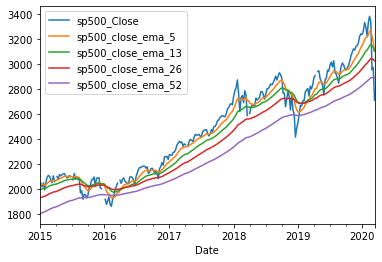

In [13]:
# ploting closing price along with its trends
df_test.iloc[:,[0,22,25,28,31]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

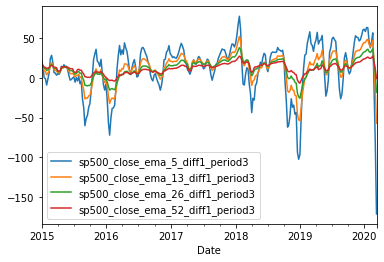

In [14]:
df_test.iloc[:,[23,26,29,32]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

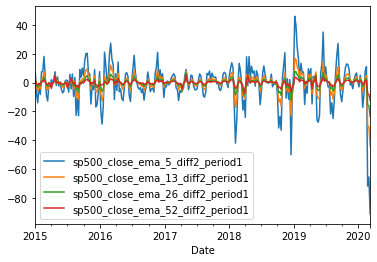

In [15]:
df_test.iloc[:,[24,27,30,33]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

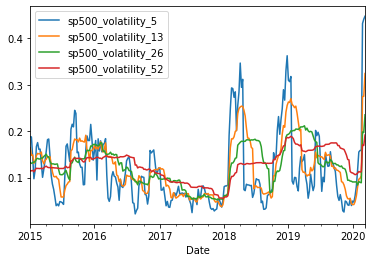

In [16]:
df_test.iloc[:,[35,38,41,44]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

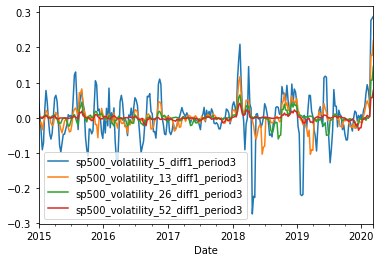

In [17]:
df_test.iloc[:,[36,39,42,45]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

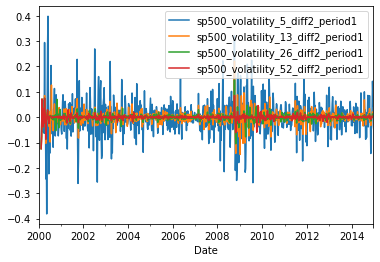

In [18]:
df_train.iloc[:,[37,40,43,46]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

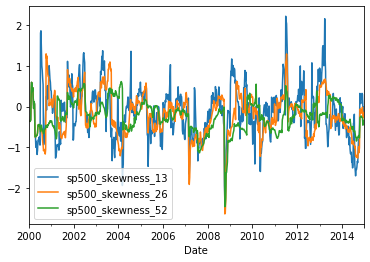

In [19]:
df_train.iloc[:,[47,49,51]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

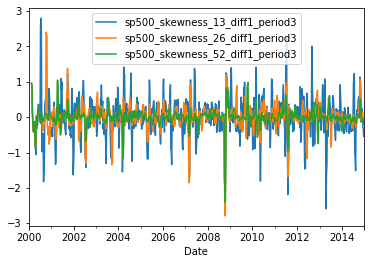

In [20]:
df_train.iloc[:,[48,50,52]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

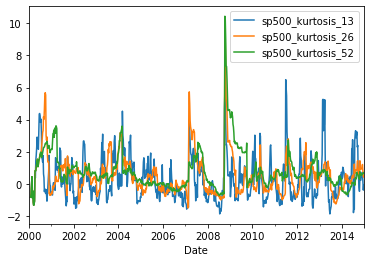

In [21]:
df_train.iloc[:,[53,55,57]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

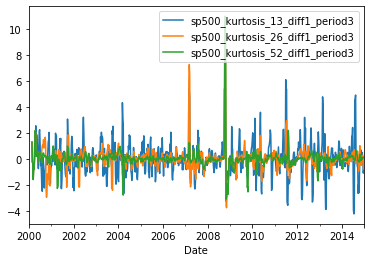

In [22]:
df_train.iloc[:,[54,56,58]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

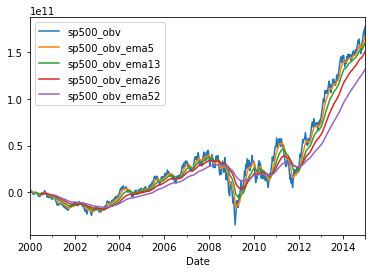

In [23]:
df_train.iloc[:,[59,60,62,64,66]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

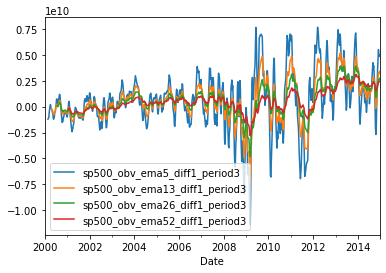

In [24]:
df_train.iloc[:,[61,63,65,67]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

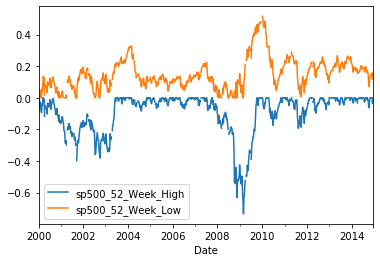

In [25]:
df_train.iloc[:,[68,70]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

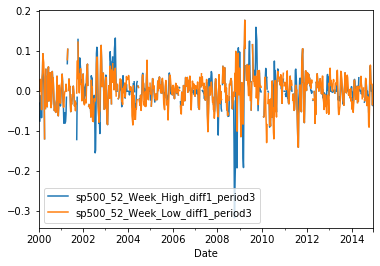

In [26]:
df_train.iloc[:,[69,71]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

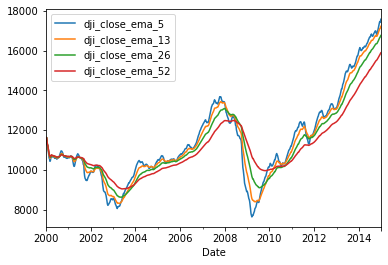

In [27]:
df_train.iloc[:,[72,75,78,81]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

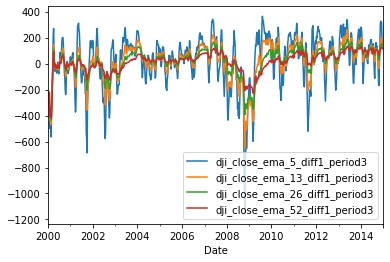

In [28]:
df_train.iloc[:,[73,76,79,82]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

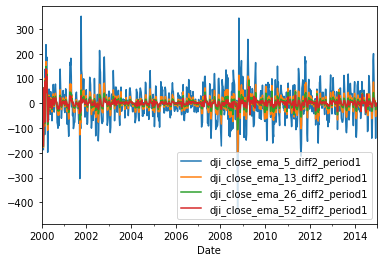

In [29]:
df_train.iloc[:,[74,77,80,83]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

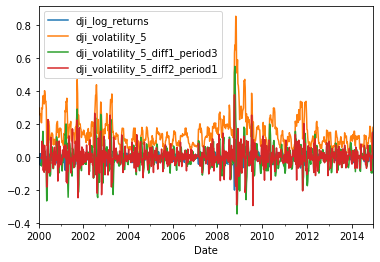

In [30]:
df_train.iloc[:,[84,85,86,87]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

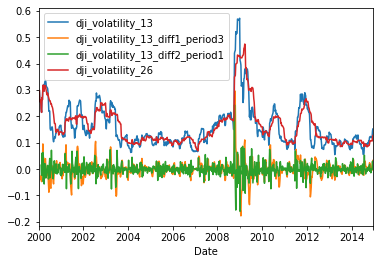

In [31]:
df_train.iloc[:,[88,89,90,91]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

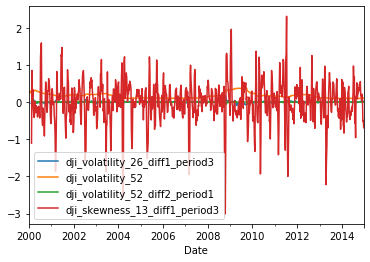

In [32]:
df_train.iloc[:,[92,94,96,98]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

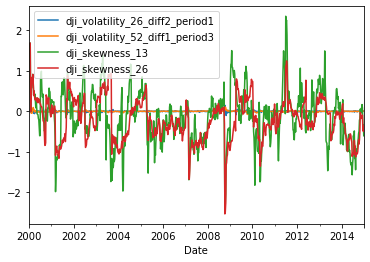

In [33]:
df_train.iloc[:,[93,95,97,99]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

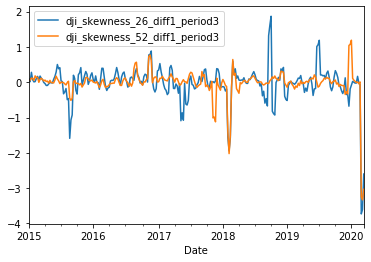

In [34]:
df_test.iloc[:,[100,102]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

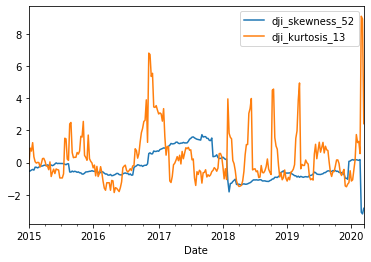

In [35]:
df_test.iloc[:,[101,103]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

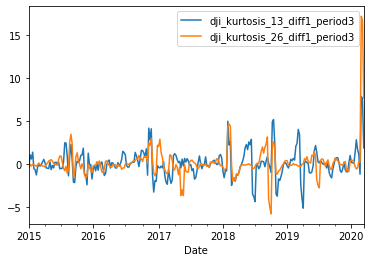

In [36]:
df_test.iloc[:,[104,106]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()

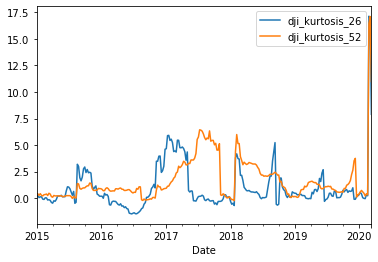

In [37]:
df_test.iloc[:,[105,107]].plot()
plt.legend(loc='best')
plt.xlabel('Date')
plt.show()